With this analysis, we explored some important features that have proved to be sound and effective in predicting phishing/malicious websites based on lexical characteristics of URL

In [19]:
import os
import sys
import re
import matplotlib
import pandas as pd
import numpy as np
from os.path import splitext
import ipaddress as ip
import tldextract
import whois
import datetime
from urllib.parse import urlparse

In [20]:
df = pd.read_csv("dataset.csv",encoding='ISO-8859-1')
df= df.sample(frac=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,url,is_spam
0,http://raszputyincat.com/index.php?option=com_...,0
1,https://uvic.ca,1
2,https://webempresa.com,1
3,https://chickteases.com,1
4,https://talentyab.com,1


In [21]:
len(df) #displaying 5 records

71716

In [22]:
#2016's top most suspicious TLD and words
Suspicious_TLD=['zip','cricket','link','work','party','gq','kim','country','science','tk']
Suspicious_Domain=['luckytime.co.kr','mattfoll.eu.interia.pl','trafficholder.com','dl.baixaki.com.br','bembed.redtube.comr','tags.expo9.exponential.com','deepspacer.com','funad.co.kr','trafficconverter.biz']
#trend micro's top malicious domains 

Hackers can use long URL to hide the doubtful part in the address bar. For example: 
http://federmacedoadv.com.br/3f/aze/ab51e2e319e51502f416dbe46b773a5e/?cmd=_home&amp;dispatch=11004d58f5b74f8dc1e7c2e8dd4105e811004d58f5b74f8dc1e7c2e8dd4105e8@phishing.website.html



In [23]:
# Method to count number of dots
def countdots(url):  
    return url.count('.')

In [24]:
# Method to count number of delimeters
def countdelim(url):
    count = 0
    delim=[';','_','?','=','&']
    for each in url:
        if each in delim:
            count = count + 1
    
    return count

If an IP address is used as an alternative of the domain name in the URL, such as “http://125.98.3.123/fake.html”, users can be sure that someone is trying to steal their personal information. Sometimes, the IP address is even transformed into hexadecimal code as shown in the following link “http://0x58.0xCC.0xCA.0x62/2/paypal.ca/index.html”. 

In [25]:
# Is IP addr present as th hostname, let's validate

import ipaddress as ip #works only in python 3

def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0

In [26]:
#method to check the presence of hyphens

def isPresentHyphen(url):
    return url.count('-')
        

Using “@” symbol in the URL leads the browser to ignore everything preceding the “@” symbol and the real address often follows the “@” symbol. 

In [27]:
#method to check the presence of @

def isPresentAt(url):
    return url.count('@')

The existence of “//” within the URL path means that the user will be redirected to another website. An example of such URL’s is: “http://www.legitimate.com//http://www.phishing.com”. We examine the presence of “//”

In [28]:
def isPresentDSlash(url):
    return url.count('//')

In [29]:
def countSubDir(url):
    return url.count('/')

In [30]:
def get_ext(url):
    """Return the filename extension from url, or ''."""
    
    root, ext = splitext(url)
    return ext

In [31]:
def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))

In [32]:
def countQueries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

In [33]:
'''
featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','create_age(months)','expiry_age(months)','update_age(days)','country','file extension','label'))'''

featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

In [34]:
from urllib.parse import urlparse
import tldextract
def getFeatures(url, label): 
    result = []
    url = str(url)
    
    #add the url to feature set
    result.append(url)
    
    #parse the URL and extract the domain information
    path = urlparse(url)
    ext = tldextract.extract(url)
    
    #counting number of dots in subdomain    
    result.append(countdots(ext.subdomain))
    
    #checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    #length of URL    
    result.append(len(url))
    
    #checking @ in the url    
    result.append(isPresentAt(path.netloc))
    
    #checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    #Count number of subdir    
    result.append(countSubDir(path.path))
    
    #number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    #length of domain name    
    result.append(len(path.netloc))
    
    #count number of queries    
    result.append(len(path.query))
    
    #Adding domain information
    
    #if IP address is being used as a URL     
    result.append(isip(ext.domain))
    
    #presence of Suspicious_TLD
    result.append(1 if ext.suffix in Suspicious_TLD else 0)
    
    #presence of suspicious domain
    result.append(1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 )
     
    '''
      
    #Get domain information by asking whois
    domain = '.'.join(ext[1:])
    w = whois.whois(domain)
    
    avg_month_time=365.2425/12.0
    
                  
    #calculate creation age in months
                  
    if w.creation_date == None or type(w.creation_date) is str :
        result.append(-1)
        #training_df['create_age(months)'] = -1
    else:
        if(type(w.creation_date) is list): 
            create_date=w.creation_date[-1]
        else:
            create_date=w.creation_date

        if(type(create_date) is datetime.datetime):
            today_date=datetime.datetime.now()
            create_age_in_mon=((today_date - create_date).days)/avg_month_time
            create_age_in_mon=round(create_age_in_mon)
            result.append(create_age_in_mon)
            #training_df['create_age(months)'] = create_age_in_mon
            
        else:
            result.append(-1)
            #training_df['create_age(months)'] = -1
    
    #calculate expiry age in months
                  
    if(w.expiration_date==None or type(w.expiration_date) is str):
        #training_df['expiry_age(months)'] = -1
        result.append(-1)
    else:
        if(type(w.expiration_date) is list):
            expiry_date=w.expiration_date[-1]
        else:
            expiry_date=w.expiration_date
        if(type(expiry_date) is datetime.datetime):
            today_date=datetime.datetime.now()
            expiry_age_in_mon=((expiry_date - today_date).days)/avg_month_time
            expiry_age_in_mon=round(expiry_age_in_mon)
            #training_df['expiry_age(months)'] = expiry_age_in_mon
            #### appending  in months Appended to the Vector
            result.append(expiry_age_in_mon)
        else:
            #training_df['expiry_age(months)'] = -1
            result.append(-1)#### expiry date error so append -1

    #find the age of last update
                  
    if(w.updated_date==None or type(w.updated_date) is str):
        #training_df['update_age(days)'] = -1
        result.append(-1)
    else:
        if(type(w.updated_date) is list):
            update_date=w.updated_date[-1]
        else:
            update_date=w.updated_date
        if(type(update_date) is datetime.datetime):
            today_date=datetime.datetime.now()
            update_age_in_days=((today_date - update_date).days)
            result.append(update_age_in_days)
            #training_df['update_age(days)'] = update_age_in_days #### appending updated age in days Appended to the Vector
        else:
            result.append(-1)
            #training_df['update_age(days)'] = -1
    
    #find the country who is hosting this domain
    if(w.country == None):
        #training_df['country'] = "None"
        result.append("None")
    else:
        #training_df['country'] = w.country
        result.append(w.country)
     ''' 
    
    #result.append(get_ext(path.path))
    result.append(str(label))
    return result
                  
    #Yay! finally done!  




a phishing website lives for a short period of time, we believe that trustworthy domains are regularly paid for several years in advance. But whois server takes few requests per day. So I commented out for now.

In [35]:
for i in range(len(df)):
    features = getFeatures(df["url"].loc[i], df["is_spam"].loc[i])    
    featureSet.loc[i] = features      

In [37]:
featureSet.head()

,url,no of dots,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,len of domain,no of queries,is IP,presence of Suspicious_TLD,presence of suspicious domain,label
0,http://raszputyincat.com/index.php?option=com_...,0,0,82,0,0,1,0,17,47,0,0,0,0
1,https://uvic.ca,0,0,15,0,0,0,0,7,0,0,0,0,1
2,https://webempresa.com,0,0,22,0,0,0,0,14,0,0,0,0,1
3,https://chickteases.com,0,0,23,0,0,0,0,15,0,0,0,0,1
4,https://talentyab.com,0,0,21,0,0,0,0,13,0,0,0,0,1


In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
from __future__ import division

Lets visualize the data

 URL length Distributions of both Malicious as well as Benign URLs. 

C:\Users\mir62\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\mir62\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


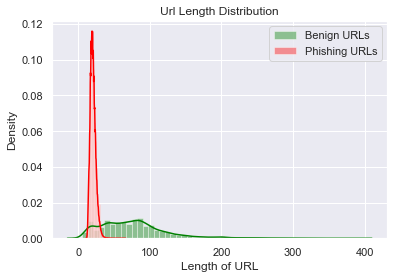

In [39]:
sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of url'],color='green',label='Benign URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of url'],color='red',label='Phishing URLs')
plt.title('Url Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.show()

Number of Dots Distributions of both Malicious as well as Benign URLs.

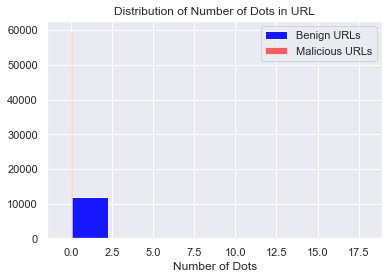

In [40]:
x=featureSet[featureSet['label']=='0']['no of dots']
y=featureSet[featureSet['label']=='1']['no of dots']
plt.hist(x,bins=8, alpha=0.9, label='Benign URLs',color='blue')
#sns.distplot(x,bins=8,color='blue',label='Benign URLs')
plt.hist(y,bins=10, alpha=0.6, label='Malicious URLs',color='red')
#sns.distplot(y,bins=8,color='red',label='Malicious URLs')
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in URL')
plt.show()

Domain length Distributions of both Malicious as well as Benign URLs.

C:\Users\mir62\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\mir62\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


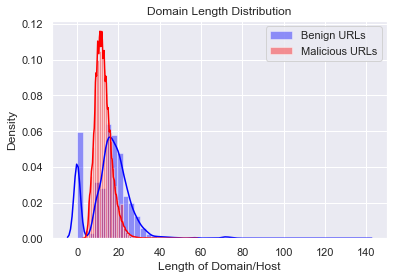

In [41]:
sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of domain'],color='blue',label='Benign URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of domain'],color='red',label='Malicious URLs')
plt.title('Domain Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')
plt.show()

In [42]:
'''
sns.set(style="whitegrid")
sns.distplot(featureSet[featureSet['label']==0]['create_age(months)'],color='green',label='Benign URLs')
sns.distplot(featureSet[featureSet['label']==1]['create_age(months)'],color='red',label='Malicious URLs')
sns.plt.title('Creation Age Distribution')
plt.legend(loc='upper right')
plt.xlabel('Age of Domain (Months)')
sns.plt.show()
'''

'\nsns.set(style="whitegrid")\nsns.distplot(featureSet[featureSet[\'label\']==0][\'create_age(months)\'],color=\'green\',label=\'Benign URLs\')\nsns.distplot(featureSet[featureSet[\'label\']==1][\'create_age(months)\'],color=\'red\',label=\'Malicious URLs\')\nsns.plt.title(\'Creation Age Distribution\')\nplt.legend(loc=\'upper right\')\nplt.xlabel(\'Age of Domain (Months)\')\nsns.plt.show()\n'

I can query minimal URL's per day using whois to get domain information. Waiting to get complete feature set, hence commented out

In [43]:
import sklearn.ensemble as ek
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

Let's just see the number of Benign and Phishin/Malicious emails

In [44]:
featureSet.groupby(featureSet['label']).size()

label
0    12020
1    59696
dtype: int64

Separate label and feature set. It would have been nice if I had domain features too. 

In [45]:
X = featureSet.drop(['url','label'],axis=1).values
y = featureSet['label'].values

### Time for Machine Learning

In [46]:
model = { "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
         "RandomForest":ek.RandomForestClassifier(n_estimators=50),
         "Adaboost":ek.AdaBoostClassifier(n_estimators=50),
         "GradientBoosting":ek.GradientBoostingClassifier(n_estimators=50),
         "GNB":GaussianNB(),
         "LogisticRegression":LogisticRegression(),
         "svm":SVC(kernel='linear',C=1.0)
}

##### cross validation

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [48]:
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

DecisionTree : 0.9999302844394868 
RandomForest : 0.9999302844394868 
Adaboost : 0.9999302844394868 
GradientBoosting : 0.9999302844394868 
GNB : 0.9730200780814278 


C:\Users\mir62\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression : 0.9989542665923034 
svm : 0.9997908533184606 


In [49]:
winner = max(results, key=results.get)
print(winner)

DecisionTree


In [50]:
clf = model[winner]
res = clf.predict(X)
mt = confusion_matrix(y, res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

False positive rate : 0.008319 %
False negative rate : 0.000000 %


### Testing

Let's test' some of the malicious URL's listed in Trend Micro's website. http://apac.trendmicro.com/apac/security-intelligence/current-threat-activity/malicious-top-ten/

In [51]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('trafficconverter.biz:80/4vir/antispyware/loadadv.exe', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['0']


Success! One more time :) 

In [52]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('am10.ru:80/code.php', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['0']
